im going to applu the workflow ive worked on in the other notebook and for simplicity trying the next project standalone so its not a long unusable notebook

a custom dataset is a collection of data relating to a specific problem, its almost anything i want it to be as long as its organized and prepared correctly. 
if trying to build a model to classify whether or not a text-based review on a website was positive or negative, the custom dataset might be examples of existing customer reviews and their ratings.
Or if trying to build a sound classification app, the custom dataset might be sound samples alongside their sample labels.
Or if trying to build a recommendation system for customers purchasing things on our website, the custom dataset might be examples of products other people have bought.
pytorch includes functions to load various custom datasets in the torchvision, torchtext, torchaudio, and torchrec libraries.
sometimes these will not be enough to do things though, in this case i can subclass torch.utils.data.Dataset and customize it.

# im gonna:
- apply the workflow ive been practicing for the last few days to a new **computer vision model**
    - get data ready
    - build or pick model
    - fit model to data 
    - make prediction
    - evaluate
    - improve
    - save
    - load
- instead of using a built in pytorch toy dataset i will be using a dataset consisting of images of pizza, steak, or sushi
- get data
- prep data
- transform data
- load data
- load custom dataset
- other transformations
- model
- explore loss curves
- augment model
- compare results
- make prediction


In [4]:
import torch
from torch import nn 
torch.__version__

'2.0.1'

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

the first thing i need is the data im going to use a subset of the food101 dataset, food101 is popular computer vision benchmark and it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test). its also preformatted for what i wanna use it for but i will learn to format as i go

In [3]:
import requests
import zipfile
from pathlib import Path

#setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#if the image folder doesn't exist, download it and prep it
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    #download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading...")
        f.write(request.content)

    #unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


now that the data has been downloaded and managed nicely (if youre better at management of data and stuff this is prolly not nicely done but i am not so it is to me)
i need to prepare the data, and get really comfortable with looking at it altering it and using it.
# data preperation seems to be one of if not the biggest and most important parts of machine learning and data science. 
before starting any project i should know what data im working with and in this case its litterally images of pizza steal and sushi in standard image classification format. image classification format contains seperate classes of images in seperate directories titled with a particular class name. all images of pizza are contained in the pizza/ directory. this format seems to be pretty popular in different image classifier benchmarks
```pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...```

In [6]:
import os
def walk_through_dir(dir_path):
    """walks through a dir_path returning its contents
    args:
        dir_path (str or pathlib.Path): target directory
    returns:
        a print out of number of subrirectories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [7]:
walk_through_dir(image_path)

there are 2 directories and 0 images in 'data/pizza_steak_sushi'
there are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
there are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
there are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
there are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
there are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
there are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
there are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
there are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'


In [9]:
#setup training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

im going to visualize the data so i can see it now
gonna get all the paths using pathlib.Path.glob() to find all files ending in .jpg, then pick random images using random.choice(), then get the image class name using pathlib.Path.parent.stem then since im working with images im gonna open the random image path using PIL image open and show the image with some data

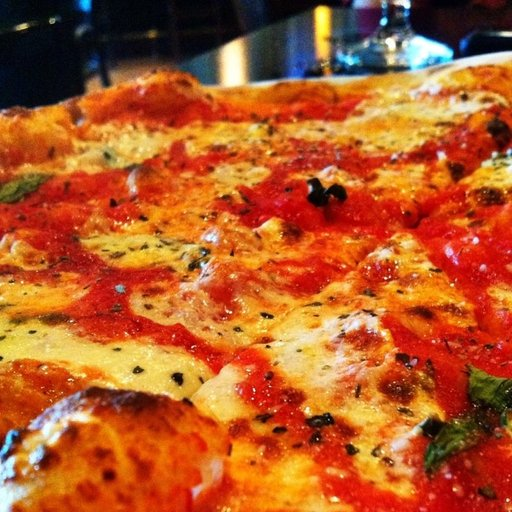

In [18]:
import random
from PIL import Image

#set seed
random.seed(42)
#get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
#get random image path
random_image_path = random.choice(image_path_list)
#get image class from path name the image class is the name of the directory the image is stored in
image_class = random_image_path.parent.stem
#open image
img = Image.open(random_image_path)

img

i can also use matplotlib but i have to convert the image to a numpy array first

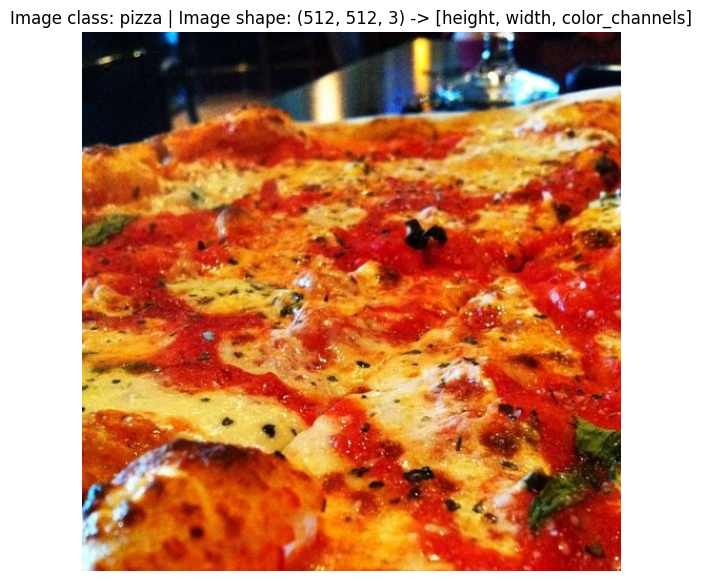

In [12]:
import numpy as np
import matplotlib.pyplot as plt

#turn image into an array
img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

i can turn everything into tensors to load the image data into pytorch now and turn it into a torch.utils.data.Dataset and torch.utils.data.DataLoader. im gonna use torchvision.datasets for the dataloading functions and torchvision.transforms for preparing our data

In [19]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

i have folders of images but before i can use them in pytorch to do cool machine learny stuff on the data i need to convert everything into tensors and i can do this by using torchvision.transforms it has a bunch of pre built methods for formatting images and turning them into tensors or manipulating them for data augmentation, altering a data to make it harder for a model to learn, im going to write a series of steps that resize the images using transforms.Resize() then flip the images randomly on the horizontal using transforms.RandomHorizontalFlip() and turn the images from a PIL image to a pytorch tensor using transforms.ToTensor() and i can complete all of this inside of torchvision.transforms.Compose()
```torchvision.transforms.Compose(transforms)[SOURCE]
Composes several transforms together. This transform does not support torchscript. Please, see the note below.

Parameters:
transforms (list of Transform objects) – list of transforms to compose.```

its kinda like nn.Sequential 

In [24]:
#write transform for image
data_transform = transforms.Compose([
    #resize the images to 64x64
    transforms.Resize(size=(64,64)),
    #flip rando on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #turn image into tensor
    transforms.ToTensor()
])

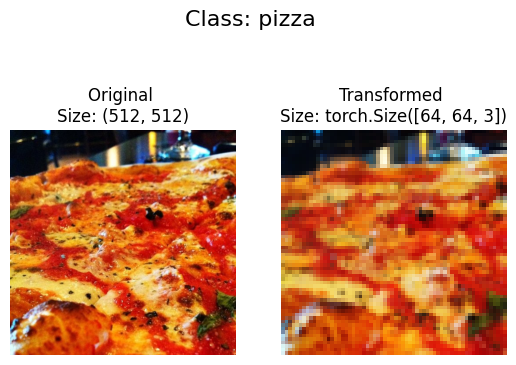

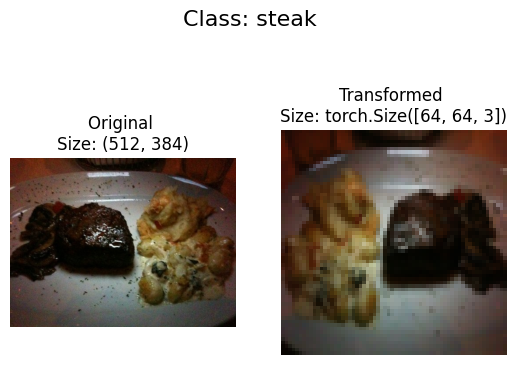

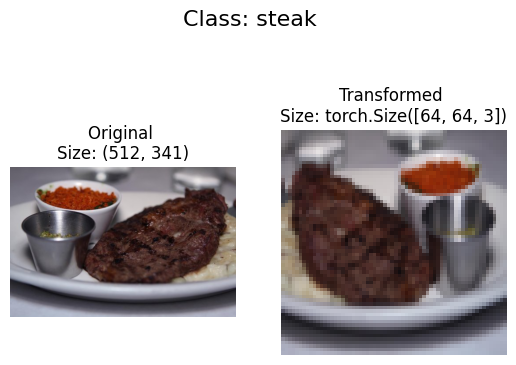

In [25]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            #transform and plot image
            #Note: permute() will change shape of image to suit matplotlib 
            #(PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

now i have a way to convert my images to tensors and manipulate them a bit if i need to. higher size/res whatever of images makes them have more data to cover and will probably yield a better result, but will take longer to compute.
im going to first learn how to load the image data using imagefolder since the data is in standrd image classification format i can use the torchvision.datasets.ImageFolder class where i can pass it the file path of a target image directory as well as a series of transforms i want to preform

In [26]:
#use imagefolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform,target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)
print(f'traindata:\n {train_data}\n testdata:\n {test_data}')

traindata:
 Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
 testdata:
 Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


the dataset has been registered

In [28]:
#get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [29]:
#can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [30]:
#check lengths
len(train_data), len(test_data)

(225, 75)

In [31]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

my images are now in the form of a tensor with shape 3, 64,64 and the labels are in the form of an integer relating to a specific class as referenced by the class to idx attribute
i have to first permute the tensor so its compatible
right not the dimensions are in chw but i need them to be in hwc 


Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


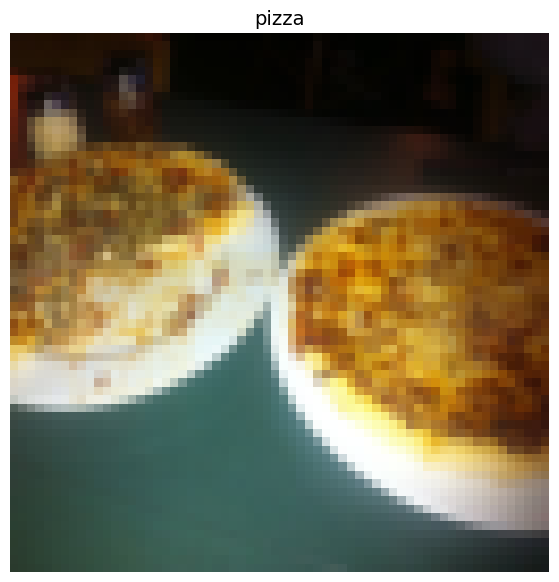

In [33]:
#rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

#print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

#plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

now i need to turn my data into a propper pytorch dataloaders
turning the data into a dataloader makes them iteratable so a model can go through and learn the relationships between samples and target data
im going to use a batch size of 1 and a num workers of 1
num workers defines how many subprocesses will be created to load the data the higher the num workers is the more compute power will be dedicated to the task. if i wanted to use every cpu core on my device rn i could use os.cpu_count()


In [34]:
#turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, #how many samples per batch?
                              num_workers=1, #how many subprocesses to use for data loading (higher = more)
                              shuffle=True) #shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) #don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2821efb90>,
 <torch.utils.data.dataloader.DataLoader at 0x282166950>)

In [35]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [36]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [37]:
#instance og torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

i need a helper function capable of creating alist of class names and a dictionary of class names and their indexes given a directory path
i need to:
- get the class names using the os.scandir() to go through the target directory
- raise an error if the class names arent found
- turn the class names into a dictionary of numerical labels one for each class
    

In [38]:
#setup path for target directory
target_directory = train_dir
print(f'target directory{target_directory}')

#get the class names from the target directory
class_names_found = sorted([entry.name] for entry in list(os.scandir(image_path/"train")))
print(f"class names found:{class_names_found}")

target directorydata/pizza_steak_sushi/train
class names found:[['pizza'], ['steak'], ['sushi']]


In [39]:
#make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """finds the class folder names in a target directory
    assumes the target directory is in standard image classification format
    
    args:
        directory (str): target directory to load classnames from
        
    returns:
        tuple[list[str], dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    #raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"couldnt find any classes in {directory}.")
    
    #create a dictionary of index labels 
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [40]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

im going to:
- subclass torch.utils.data.Dataset
- initialize the subclass with a targ_dir parameter and transdorm parameter 
- create several attributes for paths, transform, classes, and class_to_idx
- create a function to load images from file and return them this could be using PIL or torchvision.io for input/output of vision data
- overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset this is not a hard requirement its so i can call len(Dataset)
- overwrite __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset this is a hard requirement

In [42]:
#write a custom dataset class that inherets from torch.utils.data.Dataset
from torch.utils.data import Dataset

#subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    #initialize with a target directory and transform parameter
    def __init__(self, targ_dir, transform):
        #create class attributes
        #get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg')) #<--- the .jpg part needs to change for whatever i am doing respectively
        #setup transforms
        self.transforms = transform
        #create classes and class to index attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    #make function to load images
    def load_image(self, index: int) -> Image.Image:
        "opens an image via a path and returns it"
        image_path = self.paths[index]
        return Image.open(image_path)
    
    #overwrite the __len__ method 
    def __getitem__(self, index: int) -> Tuple[torch.Tensor]:
        "returns one sample of data data and label (X, y)"
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        #transform if necessary
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

the amount of code is one of the downsides to using a custom dataset but now that its been written once i can pretty much just boiler plate this as a concept and manipulate it for further use. i can turn it into a .py file like data_loader.py

In [43]:
#augment the training data
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

#dont augment testing data, only reshape it
test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,transform=train_transforms)
test_data_custom = ImageFolderCustom(target_directory=test_dir, transform=test_transforms)
